<a href="https://colab.research.google.com/github/Harshit0502/MelodyMind/blob/main/MelodyMind.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

In [30]:
data = pd.read_csv('/content/sample_data/data.csv')
data.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665


In [31]:
data.shape

(170653, 19)

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  release_date      17

In [33]:
data.isnull().sum()

,0
valence,0
year,0
acousticness,0
artists,0
danceability,0
duration_ms,0
energy,0
explicit,0
id,0
instrumentalness,0


In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  release_date      17

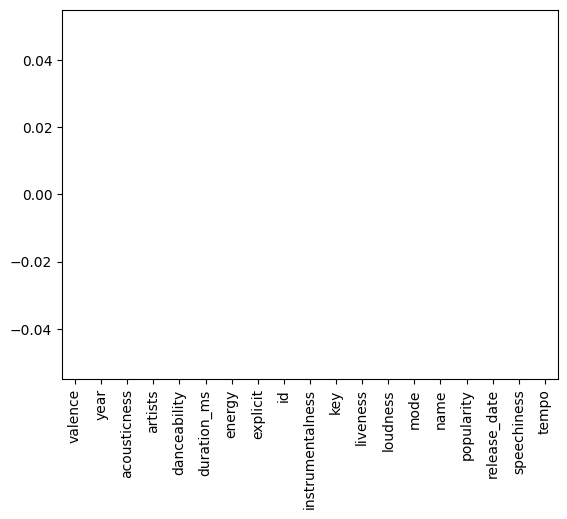

In [35]:
data.dropna(inplace = True)
data.isnull().sum().plot.bar()
plt.show()

In [36]:
data = data.drop(['id'], axis=1)


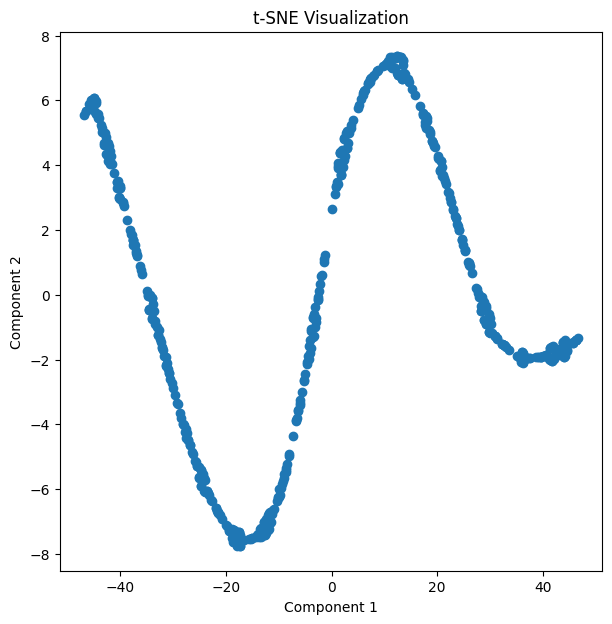

In [37]:
# Select numerical columns only for t-SNE
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
subset_data = data[numerical_columns].head(500)  # Select the first 500 rows

# Apply t-SNE
model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(subset_data)

# Plot t-SNE results
plt.figure(figsize=(7, 7))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1])
plt.title("t-SNE Visualization")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()


In [38]:
data['name'].nunique(), data.shape

(133638, (170653, 18))

In [39]:
data = data.sort_values(by=['popularity'], ascending=False)
data.drop_duplicates(subset=['name'], keep='first', inplace=True)

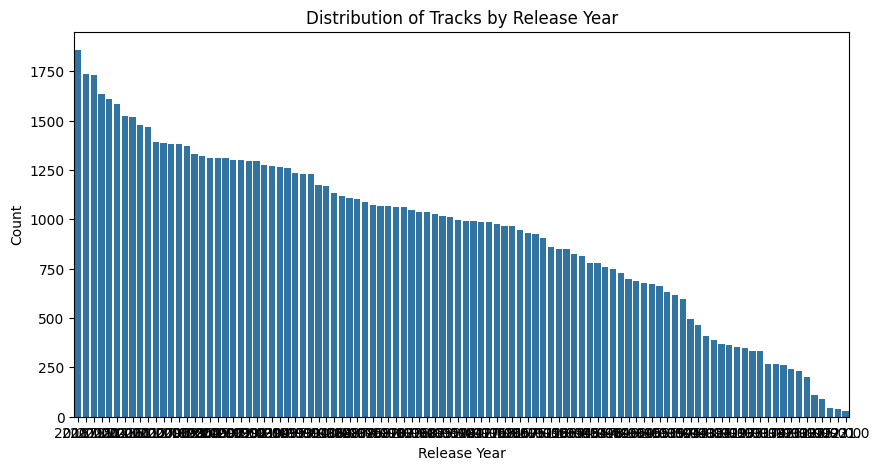

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

# Ensure 'release_date' exists and convert it to datetime
data['release_year'] = pd.to_datetime(data['release_date'], errors='coerce').dt.year

# Plot the release year distribution
plt.figure(figsize=(10, 5))
sb.countplot(data=data, x='release_year', order=data['release_year'].value_counts().index)
plt.title("Distribution of Tracks by Release Year")
plt.xlabel("Release Year")
plt.ylabel("Count")
plt.show()


In [41]:
floats = []
for col in data.columns:
  if data[col].dtype == 'float':
    floats.append(col)

len(floats)

10

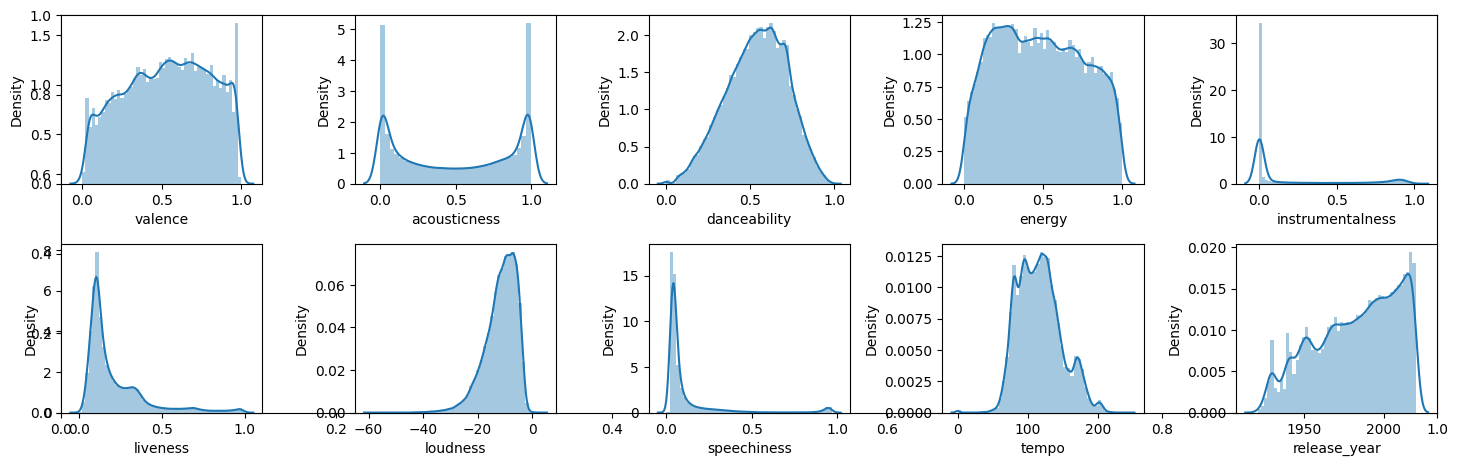

In [42]:
plt.subplots(figsize = (15, 5))
for i, col in enumerate(floats):
  plt.subplot(2, 5, i + 1)
  sb.distplot(data[col])
plt.tight_layout()
plt.show()


In [43]:
def categorize_danceability(value):
    if value < 0.4:
        return "Low Danceability"
    elif value < 0.7:
        return "Medium Danceability"
    else:
        return "High Danceability"

data['danceability_category'] = data['danceability'].apply(categorize_danceability)

# Initialize and fit CountVectorizer
song_vectorizer = CountVectorizer()
song_vectorizer.fit(data['danceability_category'])

CountVectorizer()

In [44]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def precompute_features(data):
    """
    Precompute numeric and text features for the entire dataset.
    """
    # Precompute text vectors
    text_vectors = song_vectorizer.transform(data['danceability_category']).toarray()

    # Precompute numeric feature vectors
    numeric_vectors = data.select_dtypes(include=np.number).to_numpy()

    return text_vectors, numeric_vectors

In [45]:
def get_similarities_optimized(song_name, data, text_vectors, numeric_vectors):
    """
    Calculate similarity scores in a vectorized manner.
    """
    # Find the index of the input song
    song_index = data.index[data['name'] == song_name].tolist()
    if not song_index:
        raise ValueError(f"Song '{song_name}' not found in the dataset.")
    song_index = song_index[0]

    # Get the input song's text and numeric vectors
    text_array1 = text_vectors[song_index]
    num_array1 = numeric_vectors[song_index]

    # Calculate cosine similarity for all songs (vectorized)
    text_sim = cosine_similarity([text_array1], text_vectors).flatten()
    num_sim = cosine_similarity([num_array1], numeric_vectors).flatten()

    # Combine similarities
    total_similarity = text_sim + num_sim

    return total_similarity

In [46]:
def recommend_songs_optimized(song_name, data=tracks):
    """
    Optimized function to recommend songs based on input.
    """
    # Check if the song exists
    if data[data['name'] == song_name].shape[0] == 0:
        print("This song is either not so popular or you have entered an invalid name.\nHere are some songs you may like:\n")
        for song in data.sample(n=5)['name'].values:
            print(song)
        return

    # Precompute features
    text_vectors, numeric_vectors = precompute_features(data)

    # Get similarity scores
    data['similarity_factor'] = get_similarities_optimized(song_name, data, text_vectors, numeric_vectors)

    # Sort data by similarity and popularity
    recommendations = data.sort_values(by=['similarity_factor', 'popularity'], ascending=[False, False])

    # Display the top 5 recommendations (excluding the input song)
    print(f"Recommended songs based on your choice ({song_name}):\n")
    display(recommendations[['name', 'artists']][1:6])  # Exclude the input song

In [49]:
recommend_songs_optimized("Clancy Lowered the Boom", data=tracks)
recommend_songs_optimized("Danny Boy", data=tracks)

Recommended songs based on your choice (Clancy Lowered the Boom):



,name,artists
156511,Rimjhim Nache Sawan Ki Boondaniyan,"['Rampyari', 'Shanti Sharma']"
95306,Sharmake Lajake Main,['Asha Bhosle']
128243,You're The Top,"['Sammy Davis Jr.', 'Carmen McRae']"
4069,Sugar Foot Stomp,['The Pied Pipers']
5868,Here Comes Santa Claus (Right Down Santa Claus...,"['Bing Crosby', 'The Andrews Sisters']"


Recommended songs based on your choice (Danny Boy):



,name,artists
23208,Io te vurria vasà,['Claudio Villa']
144078,"Part II, Scene 7: Hallelujah","['George Frideric Handel', 'Sir Thomas Beecham..."
23604,Bansuri Bajai Ke,['Suman Kalyanpur']
78879,Neelanjana Re,['Tarun Banerjee']
93915,Beloved Infidel (1959),['Franz Waxman']
